<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/RedClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
from IPython.display import clear_output
from sklearn.cluster import KMeans
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import zipfile
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones

In [ ]:
def carga():
  folder = '/content/drive/MyDrive/BaseDatos.zip'
  with zipfile.ZipFile(folder,'r') as zip_ref:
    zip_ref.extractall('/content/BaseDatos')

In [ ]:
def grafica(label):
  plt.figure(figsize=(16,15))
  for i, snr in enumerate(snr_levels[:20]):
    plt.subplot(5, 4, i+1)

    #Señal
    sig = data[label,snr]
    sig = np.mean(sig, axis=2)

    #Centroides
    if(label=='QAM64'):
      centroid = 64
    elif(label=='QAM16'):
      centroid = 16
    elif(label=='QPSK'):
      centroid = 4
    k_means = KMeans(n_clusters=centroid)
    k_means.fit(sig)
    centroids = k_means.cluster_centers_
    labels = k_means.labels_

    # Plot each cluster with different colors
    for j in range(0,centroid):
      plt.scatter(sig[labels == j, 0], sig[labels == j, 1])

    plt.plot(centroids[:,0],centroids[:,1],'mo',markersize=4)

    # Configuración de la gráfica
    plt.title(f'{label} - SNR {snr} dB')
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
  plt.tight_layout()
  plt.show()

In [ ]:
def images():
  images_data = []
  mod = []
  modulations = ['QPSK','QAM16','QAM64']
  for modulation in modulations:
    for i, snr in enumerate(snr_levels[:20]):
      plt.figure(figsize=(1.5,2.5))
      #Señal
      sig = data[modulation,snr]
      sig = np.mean(sig, axis=2)

      #Centroides
      if(modulation=='QAM64'):
        centroid = 64
      elif(modulation=='QAM16'):
        centroid = 16
      elif(modulation=='QPSK'):
        centroid = 4
      k_means = KMeans(n_clusters=centroid)
      k_means.fit(sig)
      labels = k_means.labels_

      # Plot each cluster with different colors
      for j in range(0,centroid):
        plt.scatter(sig[labels == j, 0], sig[labels == j, 1])

      # Hide the spines (borders around the plot), labels and ticks
      plt.xticks([])
      plt.yticks([])
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      plt.gcf().canvas.draw()

      # Capture the image data (pixel information) for each subplot
      image_data = np.frombuffer(plt.gcf().canvas.tostring_rgb(), dtype=np.uint8)
      image_data = image_data.reshape(plt.gcf().canvas.get_width_height()[::-1] + (3,))

      # Store the pixel data for this subplot
      images_data.append(image_data)
      mod.append(modulation)
    plt.close('all')
  return np.array(images_data), np.array(mod)

# Código

In [ ]:
carga()

In [ ]:
file = '/content/BaseDatos/RML2016.10a_dict.dat'
try:
  with open(file,'rb') as f:
    data = pickle.load(f,encoding='latin1')
except:
  print('Error')

In [ ]:
# Extract modulation forms from the dictionary keys
modulation_forms = list({key[0] for key in data.keys()})
snr_levels = sorted(list({key[1] for key in data.keys()}))

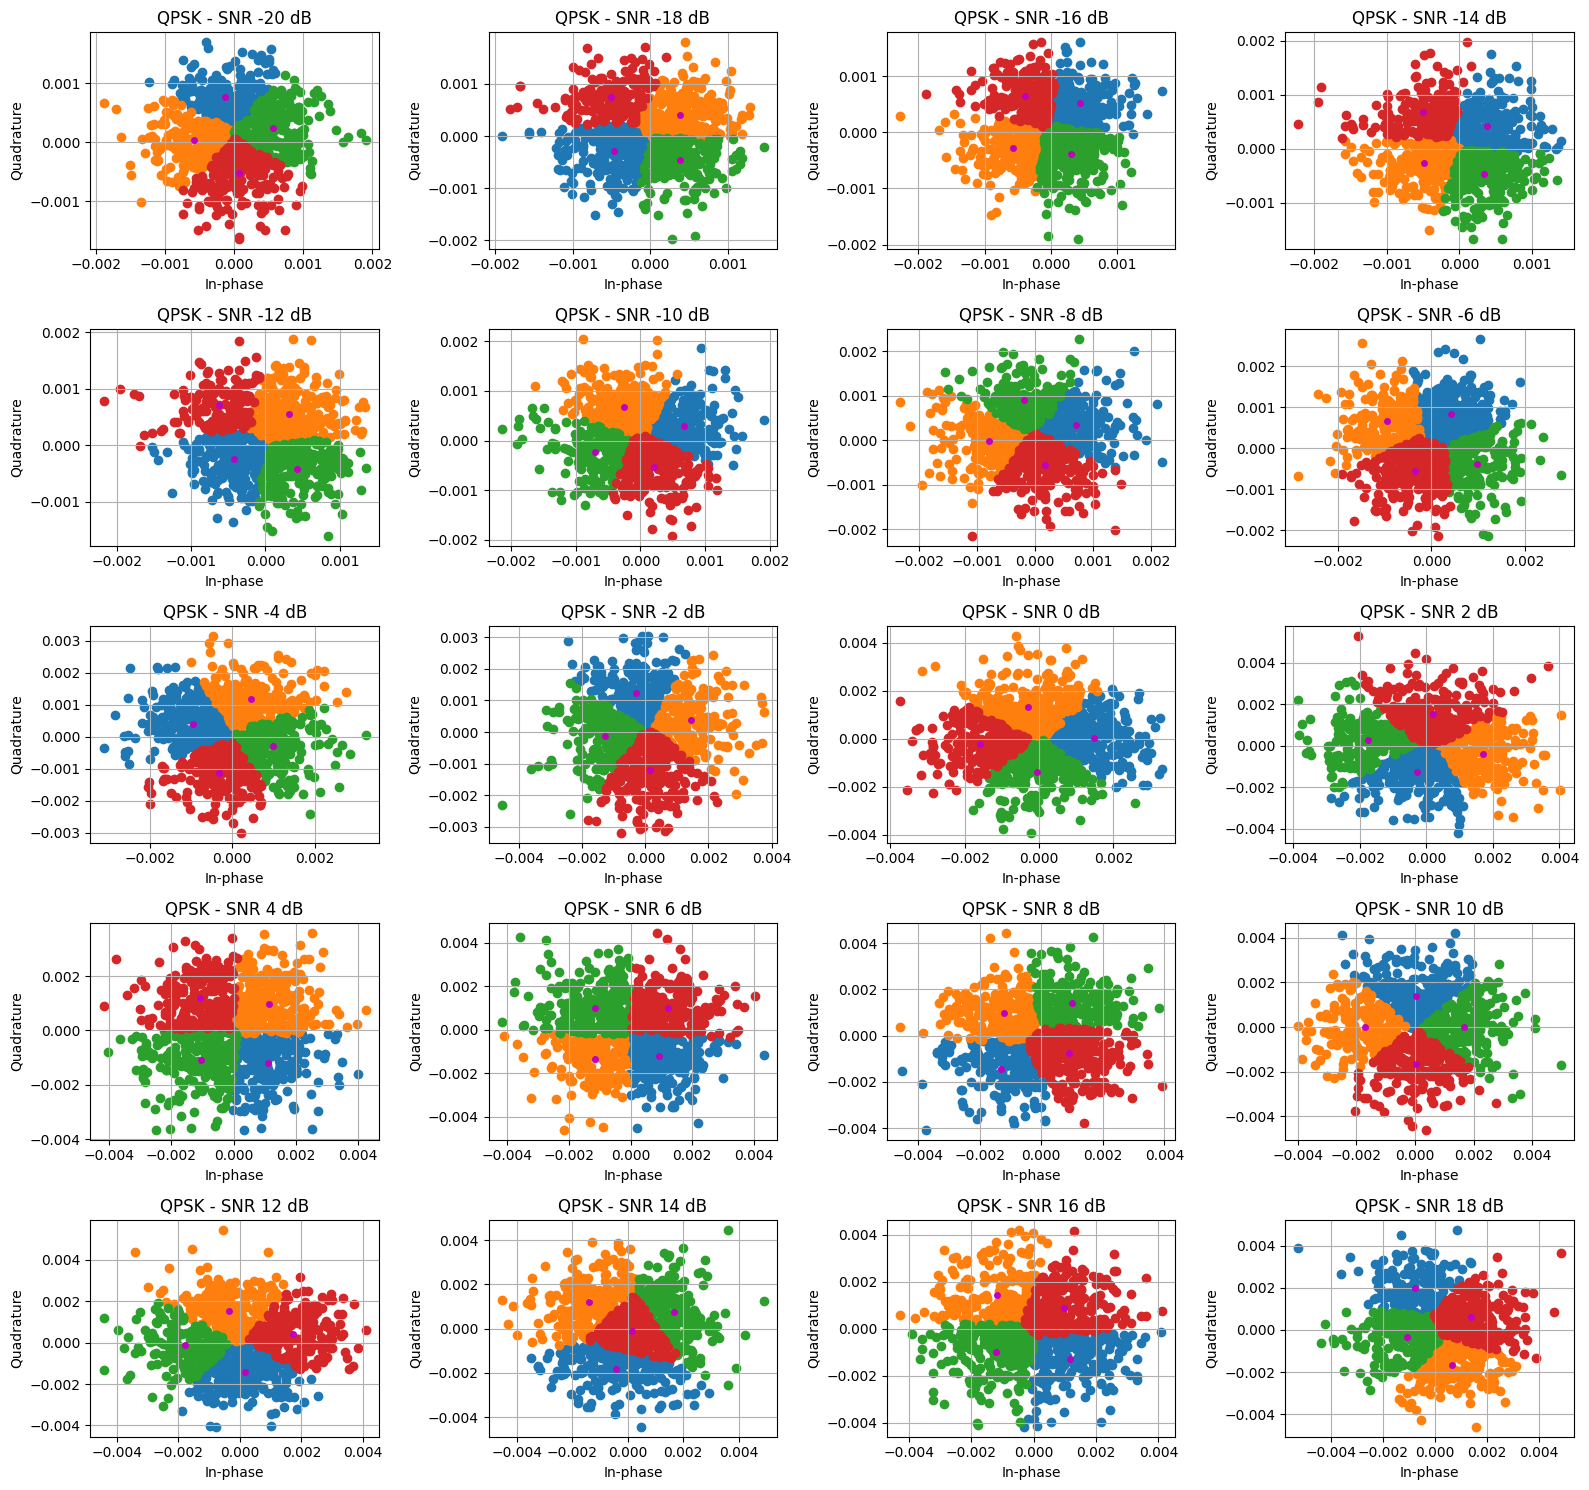

In [ ]:
grafica('QPSK')

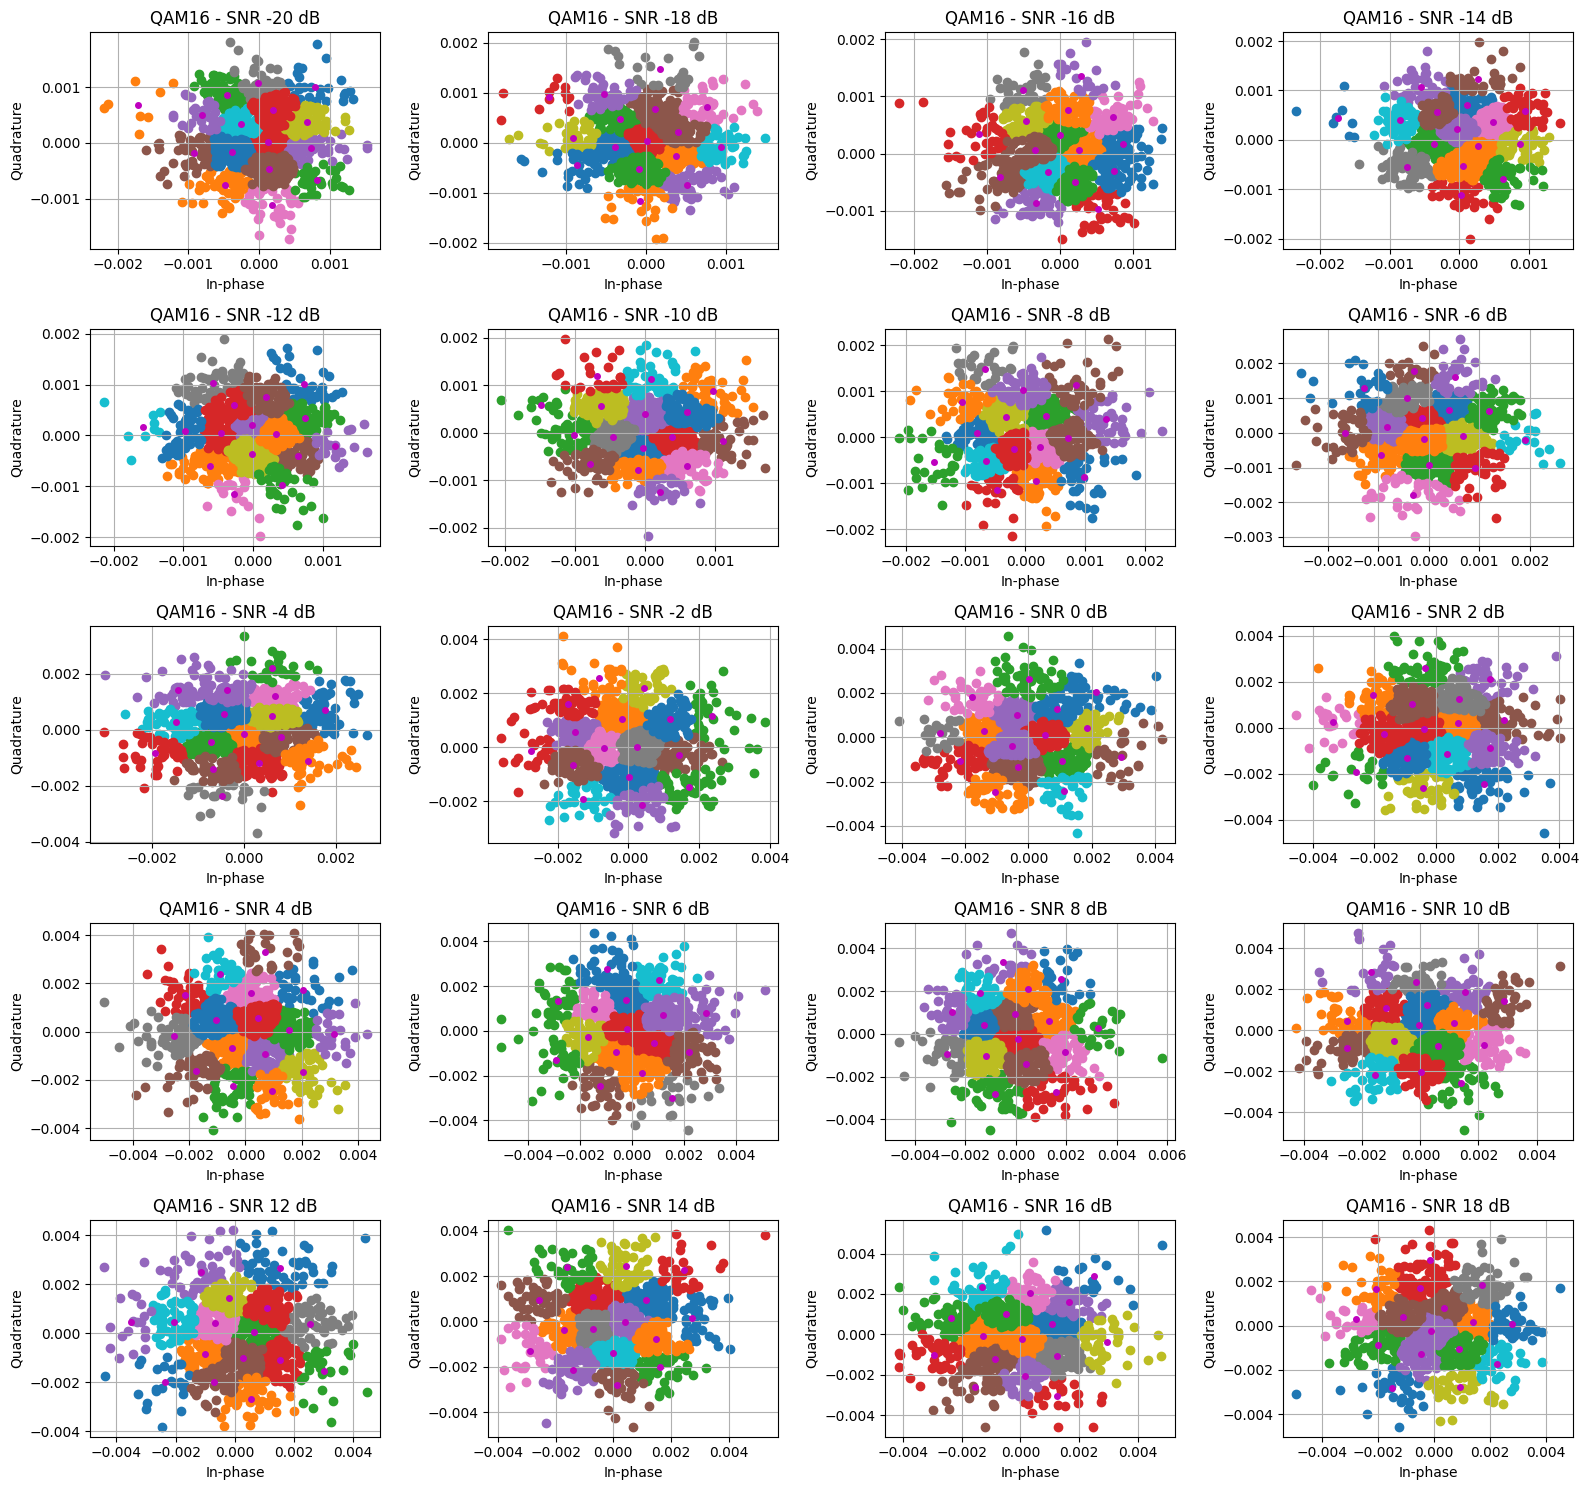

In [ ]:
grafica('QAM16')

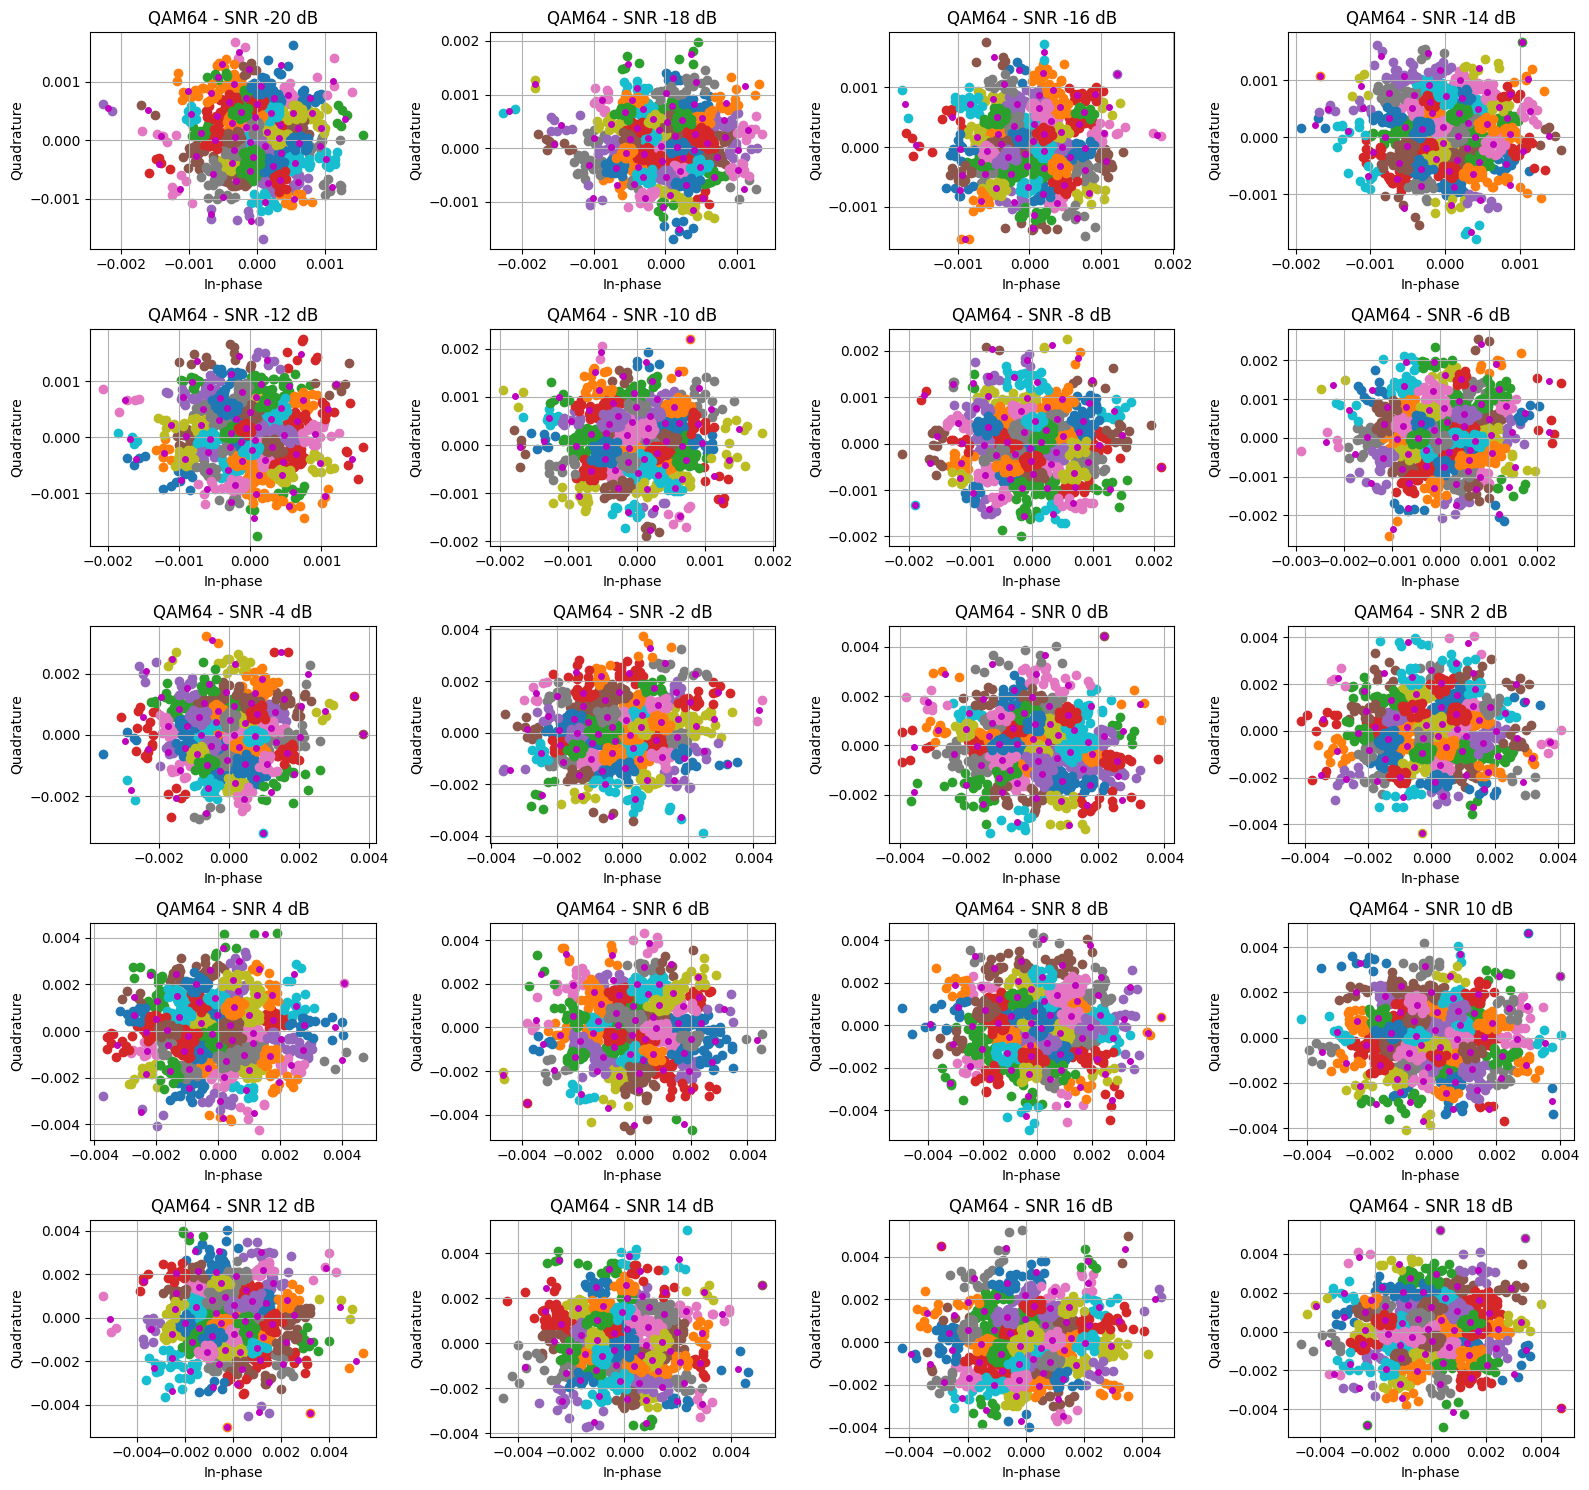

In [ ]:
grafica('QAM64')

In [ ]:
imagenes, labels = images()

In [ ]:
database = np.empty((len(imagenes),3),dtype=object)

for i in range(len(imagenes)):
  database[i][0] = imagenes[i]
  database[i][1] = labels[i]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
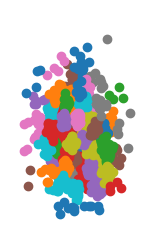

In [ ]:
database[50][0]

#Preparación de datos para la Red

In [ ]:
X = np.array([database[i][0] for i in range(len(database))])
Y = np.array([database[i][1] for i in range(len(database))])

X = X/255.0
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

img_train, img_test, label_train, label_test = train_test_split(X,Y,test_size=0.3,random_state=42)
img_train, img_val, label_train, label_val = train_test_split(img_train,label_train,test_size=0.2,random_state=42)

#Keras-Tuner

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

clear_output()

In [ ]:
from keras import layers
from keras_tuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu',
            input_shape = (100, 200, 3)
            ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu',
            ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(
            filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('kernel_size_3', values=[3, 5]),
            activation='relu',
           ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.GlobalAveragePooling2D())

    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units2", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )

    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
      model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Dense(3, activation="softmax"))

    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

build_model(keras_tuner.HyperParameters())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_1, built=True>

In [ ]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=12,  # How many models to try
    executions_per_trial=3,
    directory='tuner_results',
    project_name='modulation_classification'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(img_train, label_train, epochs=60, validation_data=(img_val, label_val))

Trial 12 Complete [00h 01m 25s]
val_loss: 1.082278847694397

Best val_loss So Far: 0.8690418004989624
Total elapsed time: 00h 16m 02s


In [ ]:
import shutil
# Eliminar el directorio donde se almacenan los resultados de la búsqueda
shutil.rmtree('tuner_results', ignore_errors=True)

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)

# Summary of the best model
model = best_model[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.save('best_model.keras')

#Clasificador

In [ ]:
from keras.models import load_model

# Load the model from the 'saved_model' directory
model = load_model('best_model.keras')

In [ ]:
# Predict on new data
predictions = model.predict(img_test)

predictions = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_test, axis=1)

prediction_classes = le.inverse_transform(predictions)
true_label = le.inverse_transform(true_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Accuracy: 100.00%


['QPSK' 'QPSK' 'QAM16' 'QAM64' 'QPSK' 'QAM64' 'QAM16' 'QAM64' 'QPSK'
 'QAM64' 'QAM64' 'QAM64' 'QAM16' 'QPSK' 'QAM64' 'QPSK' 'QPSK' 'QPSK']
['QPSK' 'QPSK' 'QAM16' 'QAM64' 'QPSK' 'QAM64' 'QAM16' 'QAM64' 'QPSK'
 'QAM64' 'QAM64' 'QAM64' 'QAM16' 'QPSK' 'QAM64' 'QPSK' 'QPSK' 'QPSK']
